The following code starts the multi client script in the background and records load balancer metrics at regular intervals to analyse.

Multi client simulation started. See Jupyter's stdout for logs
Started fetching metrics at a regular interval
Multi client simulation finished
Final state of metrics:
{'totalRequests': 500, 'totalSuccesses': 500, 'totalFailures': 0, 'overallLatency': '0ms', 'serverNodeMetrics': [{'url': 'http://server1:8081', 'requestCount': 125, 'successCount': 125, 'failureCount': 0, 'averageLatency': '0ms'}, {'url': 'http://server2:8082', 'requestCount': 250, 'successCount': 250, 'failureCount': 0, 'averageLatency': '0ms'}, {'url': 'http://server3:8083', 'requestCount': 125, 'successCount': 125, 'failureCount': 0, 'averageLatency': '0ms'}]}


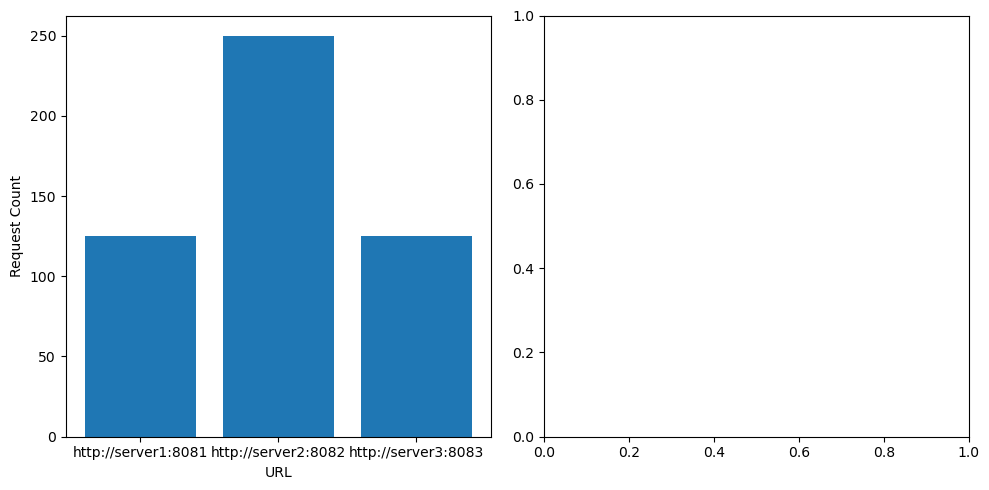

In [60]:
import collections
import requests
import subprocess
import sys
import time

import matplotlib
import matplotlib.pyplot as plt

LB_URL = "http://localhost:8080"
REQUEST_COUNT = 100
CLIENT_COUNT = 5
METRICS_BUFFER_MAXLEN = 30
METRIC_INTERVAL = 5

# Run multi client script in background process
multi_client_process = subprocess.Popen(["go", "run", "../demo/multi-client/", LB_URL, str(REQUEST_COUNT), str(CLIENT_COUNT)],
                                        stdout=sys.stdout)
print("Multi client simulation started. See Jupyter's stdout for logs")

# Store most recent metrics
metrics_buffer = collections.deque(maxlen=METRICS_BUFFER_MAXLEN)

# While multi client script process is still running
print("Started fetching metrics at a regular interval")
while multi_client_process.poll() is None:
    
    # Fetch metrics
    response = requests.get(LB_URL + "/metrics")

    # Save metric data
    metrics_buffer.append(response.json())

    time.sleep(METRIC_INTERVAL)

print("Multi client simulation finished")
print("Final state of metrics:")
print(metrics_buffer[len(metrics_buffer) - 1])

# Set width and height of figure
plt.rcParams["figure.figsize"] = [10, 5]

figure, axis = plt.subplots(nrows=1, ncols=2)

def plot_request_count_bar_chart(axes: matplotlib.axes.Axes):
    """Plot request count bar chart.

    Args:
        axes (plt.axes.Axes): The axes object to plot to.
    
    """
    urls = [server_node_metric["url"] for server_node_metric in metrics_buffer[len(metrics_buffer) - 1]["serverNodeMetrics"]]
    request_counts = [server_node_metric["requestCount"] for server_node_metric in metrics_buffer[len(metrics_buffer) - 1]["serverNodeMetrics"]]
    
    axes.set_xlabel("URL")
    axes.set_ylabel("Request Count")
    axes.bar(urls, request_counts)

plot_request_count_bar_chart(axis[0])

plt.tight_layout()
plt.show()
